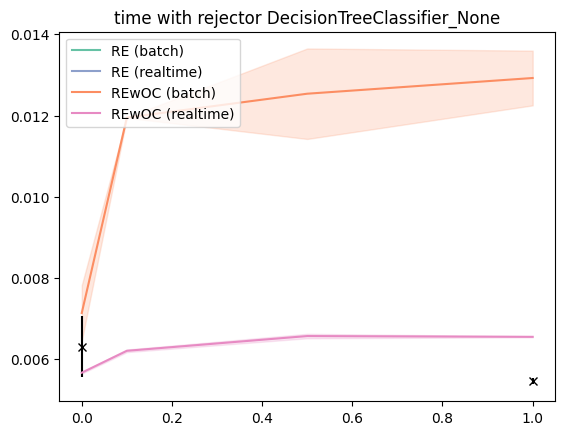

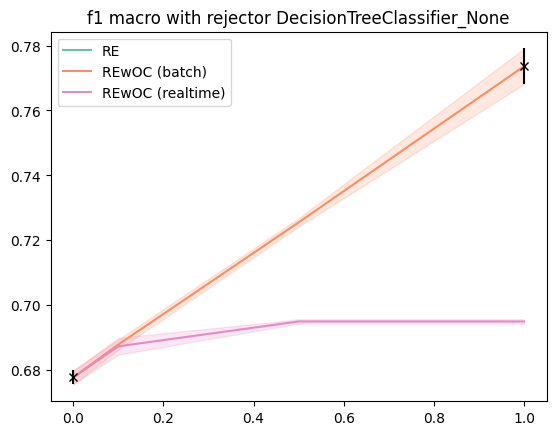

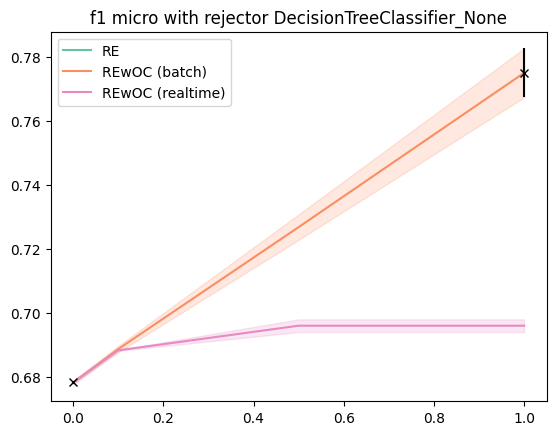

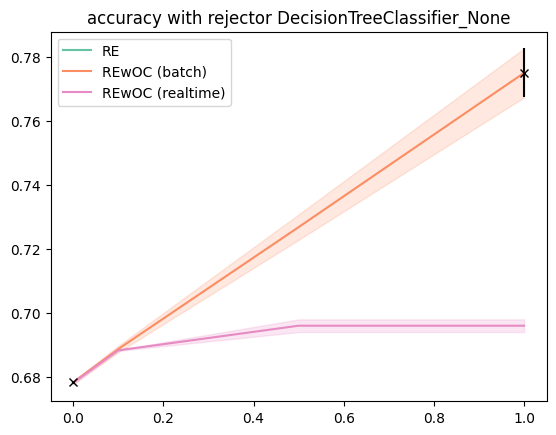

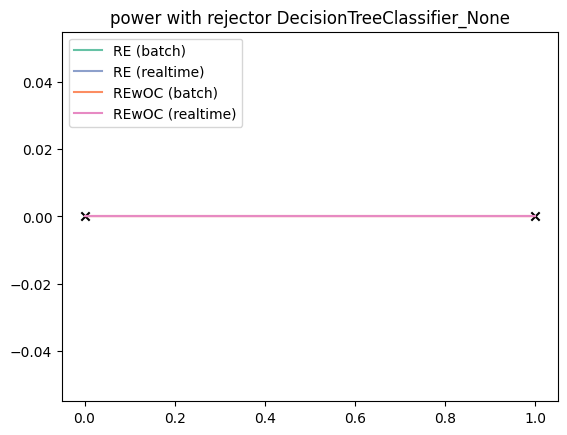

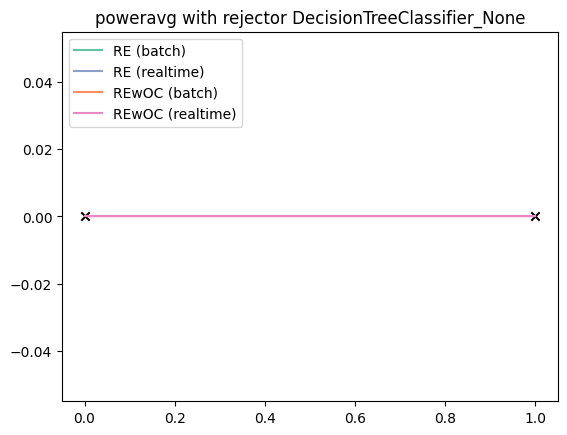

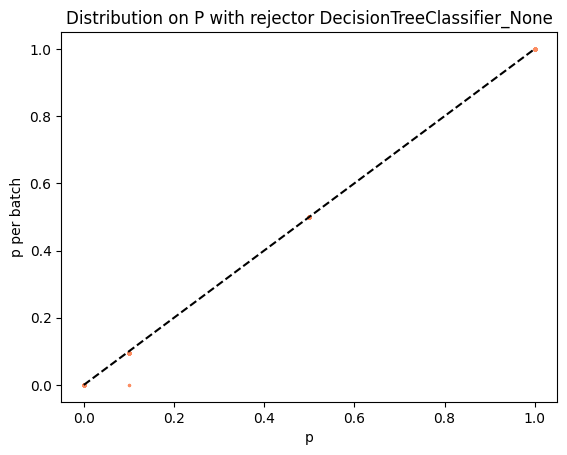

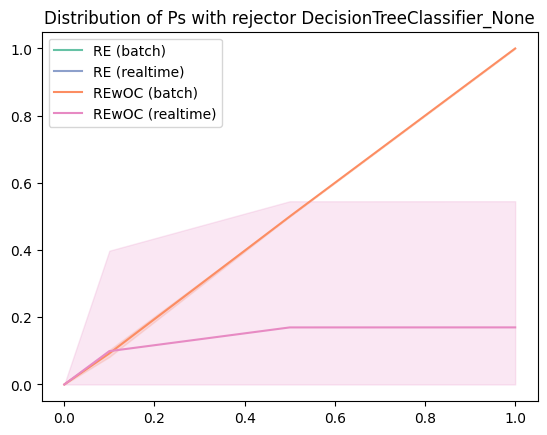

In [42]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from matplotlib.patches import PathPatch
from matplotlib.path import Path
plt.rcParams['text.usetex'] = False

def draw_error_band(ax, x, y, err, **kwargs):
    # Calculate normals via centered finite differences (except the first point
    # which uses a forward difference and the last point which uses a backward
    # difference).
    dx = np.concatenate([[x[1] - x[0]], x[2:] - x[:-2], [x[-1] - x[-2]]])
    dy = np.concatenate([[y[1] - y[0]], y[2:] - y[:-2], [y[-1] - y[-2]]])
    l = np.hypot(dx, dy)
    nx = dy / l
    ny = -dx / l

    # end points of errors
    xp = x + nx * err
    yp = y + ny * err
    xn = x - nx * err
    yn = y - ny * err

    vertices = np.block([[xp, xn[::-1]],
                         [yp, yn[::-1]]]).T
    codes = np.full(len(vertices), Path.LINETO)
    codes[0] = codes[len(xp)] = Path.MOVETO
    path = Path(vertices, codes)
    ax.add_patch(PathPatch(path, **kwargs))

metrics = json.load(open("cifar100.json","r"))

df_metrics = [{
    "model":m["model"],
    "rejector":m["rejector"],
    "run":m["run"],
    "batch":m["batch"],
    "p":m["p"],
    "f1 macro":m["f1 macro"],
    "f1 micro":m["f1 micro"],
    "accuracy":m["accuracy"],
    "time":np.mean(m["time"]),
    "power":np.mean(m["power_per_batch"]),
    "poweravg":np.mean(m["poweravg_per_batch"])
} for m in metrics]

df = pd.DataFrame(df_metrics)
# # The small model is always used when p = 0, but CIFARModelWrapper always returns the batch count. For the small model we fix it here with setting preal/pmax/pmin to 0.
# df[df["model"] == "small"]["pmin"] = 0
# df[df["model"] == "small"]["pmax"] = 0
# df[df["model"] == "small"]["preal"] = 0

agg = {
    "time":['mean','std'],
    "f1 macro":['mean','std'],
    "f1 micro":['mean','std'],
    "accuracy":['mean','std'],
    "power":['mean','std'],
    "poweravg":['mean','std'],
    # "preal":['mean','std'],
    # "pmin":['mean','std'],
    # "pmax":['mean','std'],
}

df = df.groupby(["model", "rejector", "p", "batch"], dropna=False).agg(agg)
df.reset_index(inplace=True)
# display(df)
colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3']

for m in df["rejector"].dropna().unique():
    dff = df[df["rejector"] == m]
    for key in agg.keys():
        ysmall = df[(df["model"] == "small") & (df["batch"] == True)][key]["mean"].values[0]
        ysmall_std = df[(df["model"] == "small") & (df["batch"] == True)][key]["std"].values[0]
        ybig = df[(df["model"] == "big") & (df["batch"] == True)][key]["mean"].values[0]
        ybig_std = df[(df["model"] == "big") & (df["batch"] == True)][key]["std"].values[0]

        re_p_batch = dff[(dff["model"] == "RE") & (dff["batch"] == True)]["p"]
        re_mean_batch = dff[(dff["model"] == "RE") & (dff["batch"] == True)][key]["mean"]
        re_std_batch = dff[(dff["model"] == "RE") & (dff["batch"] == True)][key]["std"]
        rewoc_p_batch = dff[(dff["model"] == "REwOC") & (dff["batch"] == True)]["p"]
        rewoc_mean_batch = dff[(dff["model"] == "REwOC") & (dff["batch"] == True)][key]["mean"]
        rewoc_std_batch = dff[(dff["model"] == "REwOC") & (dff["batch"] == True)][key]["std"]

        re_p_realtime = dff[(dff["model"] == "RE") & (dff["batch"] == False)]["p"]
        re_mean_realtime = dff[(dff["model"] == "RE") & (dff["batch"] == False)][key]["mean"]
        re_std_realtime = dff[(dff["model"] == "RE") & (dff["batch"] == False)][key]["std"]
        rewoc_p_realtime = dff[(dff["model"] == "REwOC") & (dff["batch"] == False)]["p"]
        rewoc_mean_realtime = dff[(dff["model"] == "REwOC") & (dff["batch"] == False)][key]["mean"]
        rewoc_std_realtime = dff[(dff["model"] == "REwOC") & (dff["batch"] == False)][key]["std"]

        plt.title(f"{key} with rejector {m}")
        if ysmall_std > 0 and ybig_std > 0:
            plt.errorbar([0, 1], [ysmall, ybig], yerr = [ysmall_std, ybig_std], c = "k", fmt='x')
        else:
            plt.scatter([0, 1], [ysmall, ybig], c = "k", marker='x')
        
        if key in ["f1 micro", "f1 macro", "accuracy"]:
            plt.plot(re_p_batch, re_mean_batch , color=colors[0], label="RE")
            plt.fill_between(re_p_batch, re_mean_batch - re_std_batch, re_mean_batch + re_std_batch, color=colors[0], alpha=0.2)
        else: 
            plt.plot(re_p_batch, re_mean_batch , color=colors[0], label="RE (batch)")
            plt.fill_between(re_p_batch, re_mean_batch - re_std_batch, re_mean_batch + re_std_batch, color=colors[0], alpha=0.2)

            plt.plot(re_p_realtime, re_mean_realtime , color=colors[2], label="RE (realtime)")
            plt.fill_between(re_p_realtime, re_mean_realtime - re_std_realtime, re_mean_realtime + re_std_realtime, color=colors[2], alpha=0.2)

        plt.plot(rewoc_p_batch, rewoc_mean_batch, color=colors[1], label="REwOC (batch)")
        plt.fill_between(rewoc_p_batch, rewoc_mean_batch - rewoc_std_batch, rewoc_mean_batch + rewoc_std_batch, color=colors[1], alpha=0.2)


        plt.plot(rewoc_p_realtime, rewoc_mean_realtime, color=colors[3], label="REwOC (realtime)")
        plt.fill_between(rewoc_p_realtime, rewoc_mean_realtime - rewoc_std_realtime, rewoc_mean_realtime + rewoc_std_realtime, color=colors[3], alpha=0.2)

        plt.legend(loc='upper left')
        plt.show()

for rejector in df["rejector"].dropna().unique():
    p_rewoc = []
    x_rewoc = []
    p_re = []
    x_re = []
    
    for m in metrics:
        # These scatter plots only make sense in the batch setting
        if m["batch"]:
            if m["rejector"] == rejector and m["model"] == "REwOC":
                p_rewoc.extend(m["p_per_batch"])
                x_rewoc.extend([m["p"] for _ in range(len(m["p_per_batch"]))])
            elif m["rejector"] == rejector and m["model"] == "RE":
                p_re.extend(m["p_per_batch"])
                x_re.extend([m["p"] for _ in range(len(m["p_per_batch"]))])
    plt.xlabel("p")
    plt.ylabel("p per batch")
    plt.title(f"Distribution on P with rejector {rejector}")
    plt.scatter(x_re, p_re, c = colors[0], label="RE", marker='x', s=1.5)
    plt.scatter(x_rewoc, p_rewoc, c = colors[1], label="REwOC", marker='o', s=2)
    plt.plot([0,1],[0,1], c="k", linestyle="--")
    plt.show()


for rejector in df["rejector"].dropna().unique():
    x_rewoc_batch = []
    y_rewoc_batch = []
    x_re_batch = []
    y_re_batch = []

    x_rewoc_realtime = []
    y_rewoc_realtime = []
    x_re_realtime = []
    y_re_realtime = []

    data = []
    for m in metrics:
        data.append({
            "model":m["model"],
            "run":m["run"],
            "batch":m["batch"],
            "rejector":m["rejector"],
            "p":m["p"],
            "y": np.mean(m["p_per_batch"]),
            "y_std":np.std(m["p_per_batch"])
        })


    df = pd.DataFrame(data)
    agg = {
        "y":['mean'],
        "y_std":['mean'],
    }

    dff = df.groupby(["model", "rejector", "p", "batch"], dropna=False).agg(agg)
    dff.reset_index(inplace=True)

    # display(dff)

    re_p_batch = dff[(dff["model"] == "RE") & (dff["batch"] == True)]["p"]
    re_mean_batch = dff[(dff["model"] == "RE") & (dff["batch"] == True)]["y"]["mean"]
    re_std_batch = dff[(dff["model"] == "RE") & (dff["batch"] == True)]["y_std"]["mean"]
    rewoc_p_batch = dff[(dff["model"] == "REwOC") & (dff["batch"] == True)]["p"]
    rewoc_mean_batch = dff[(dff["model"] == "REwOC") & (dff["batch"] == True)]["y"]["mean"]
    rewoc_std_batch = dff[(dff["model"] == "REwOC") & (dff["batch"] == True)]["y_std"]["mean"]

    re_p_realtime = dff[(dff["model"] == "RE") & (dff["batch"] == False)]["p"]
    re_mean_realtime = dff[(dff["model"] == "RE") & (dff["batch"] == False)]["y"]["mean"]
    re_std_realtime = dff[(dff["model"] == "RE") & (dff["batch"] == False)]["y_std"]["mean"]
    rewoc_p_realtime = dff[(dff["model"] == "REwOC") & (dff["batch"] == False)]["p"]
    rewoc_mean_realtime = dff[(dff["model"] == "REwOC") & (dff["batch"] == False)]["y"]["mean"]
    rewoc_std_realtime = dff[(dff["model"] == "REwOC") & (dff["batch"] == False)]["y_std"]["mean"]

    plt.title(f"Distribution of Ps with rejector {rejector}")
    plt.plot(re_p_batch.values, re_mean_batch.values, color=colors[0], label="RE (batch)")
    plt.fill_between(re_p_batch, np.maximum(0, re_mean_batch - re_std_batch), np.minimum(1, re_mean_batch + re_std_batch), color=colors[0], alpha=0.2)

    plt.plot(re_p_realtime, re_mean_realtime , color=colors[2], label="RE (realtime)")
    plt.fill_between(re_p_realtime, np.maximum(0, re_mean_realtime - re_std_realtime), np.minimum(1, re_mean_realtime + re_std_realtime), color=colors[2], alpha=0.2)

    plt.plot(rewoc_p_batch, rewoc_mean_batch, color=colors[1], label="REwOC (batch)")
    plt.fill_between(rewoc_p_batch, np.maximum(0, rewoc_mean_batch - rewoc_std_batch), np.minimum(1, rewoc_mean_batch + rewoc_std_batch), color=colors[1], alpha=0.2)

    plt.plot(rewoc_p_realtime, rewoc_mean_realtime, color=colors[3], label="REwOC (realtime)")
    plt.fill_between(rewoc_p_realtime, np.maximum(0, rewoc_mean_realtime - rewoc_std_realtime), np.minimum(1, rewoc_mean_realtime + rewoc_std_realtime), color=colors[3], alpha=0.2)

    plt.legend(loc='upper left')
    plt.show()

    # display(df)
    # asd

        # if m["batch"] == b:
        #     if m["rejector"] == rejector and m["model"] == "RE":
        #         if not m["run"] in data:
        #             data[m["run"]] = {
        #             }
        #         else:
        #             if m["p"] not in data[m["run"]]:
        #                 data[m["run"]][m["p"]] = []
        #             tmp = (~(np.array(m["p_per_batch"]) <= m["p"])).astype(int)
        #             data[m["run"]][m["p"]].extend(tmp)
                    #data[m["run"]][m["p"]] = m["p"]
    # for run in data:
    #     for p in data[run]:
    #         data[run][p] = np.mean(data[run][p])
    # x = []
    # y = []
    # yerr = []
    # for p in sorted(data[0].keys()):
    #     x.append(p)
    #     tmp = []
    #     for k in data.keys():
    #         tmp.append(data[k][p])
    #     y.append(np.mean(tmp))
    #     yerr.append(np.std(tmp))
    
    # y = np.array(y)
    # yerr = np.array(yerr)
    # plt.xlabel("p")
    # plt.ylabel("Percentage of failed batches")
    # plt.title(f"Percetange of batches with failed budget and rejector {rejector}")
    # plt.plot(x, y, c = "b")
    # plt.fill_between(x, y - yerr, y + yerr, color='blue', alpha=0.2)
    # plt.show()

In [31]:
~(np.array(m["p_per_batch"]) <= ps)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False,  True,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,